In [ ]:
import torch
from torchvision import models, transforms, datasets
from torchvision.models import 
from torch import nn, optim
from torch.utils.data import DataLoader


from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm

from utils import  full_loss, tsne_visualization, CIFAR100CoarseUnbalanced, sparse2coarse

In [2]:
transform = transforms.Compose([transforms.Resize((32, 32)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = datasets.CIFAR100(root='./data', train=True, download=False, transform=transform)
valset = datasets.CIFAR100(root='./data', train=False, download=False, transform=transform)

unbalanced_trainset = CIFAR100CoarseUnbalanced(trainset)

In [ ]:
batch_size = 256

trainloader = DataLoader(trainset, batch_size = batch_size, shuffle=True, num_workers = 6)
valloader = DataLoader(valset, batch_size = 2*batch_size, shuffle=False, num_workers = 6)

epochs = 8
model = models.resnet50(ResNet50_Weights.IMAGENET1K_V2)
model.fc = nn.Identity()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheudler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)


train_loss_history = []
val_loss_history = []
device_id = 1

device = torch.device(f'cuda:{device_id}' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
alpha = 0.6

/home/infres/egardes-21/.local/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [34]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_steps = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        features = model(images)
        loss = full_loss(features, labels, alpha = alpha)
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
    
    train_loss_history.append(train_loss / total_steps)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps
        for i, (images, labels, _) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            features = model(images)
            loss = full_loss(features, labels, alpha = alpha)
            val_loss += loss.item()
            total_steps += 1    
        val_loss_history.append(val_loss / total_steps)
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}')
    scheudler.step()

100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

Epoch: 0, Loss: 3.703569675746717


Epoch: 0, Val Loss: 0.6184858842329546


100%|██████████| 19/19 [00:08<00:00,  2.27it/s]

Epoch: 1, Loss: 3.5159209151017037


Epoch: 1, Val Loss: 0.5987753868103027


100%|██████████| 19/19 [00:08<00:00,  2.28it/s]

Epoch: 2, Loss: 3.46400122893484


Epoch: 2, Val Loss: 0.6044738509438254


100%|██████████| 19/19 [00:08<00:00,  2.30it/s]

Epoch: 3, Loss: 3.45959116283216


Epoch: 3, Val Loss: 0.5937170440500433


100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

Epoch: 4, Loss: 3.451783381010357


Epoch: 4, Val Loss: 0.6153234351765026


100%|██████████| 19/19 [00:08<00:00,  2.26it/s]

Epoch: 5, Loss: 3.460895111686305


Epoch: 5, Val Loss: 0.6160179051485929


100%|██████████| 19/19 [00:08<00:00,  2.31it/s]

Epoch: 6, Loss: 3.4445070091046786


Epoch: 6, Val Loss: 0.603339823809537


100%|██████████| 19/19 [00:08<00:00,  2.23it/s]

Epoch: 7, Loss: 3.4190299636439274


Epoch: 7, Val Loss: 0.6110621799122203


Text(0.5, 1.0, 'Val Loss')

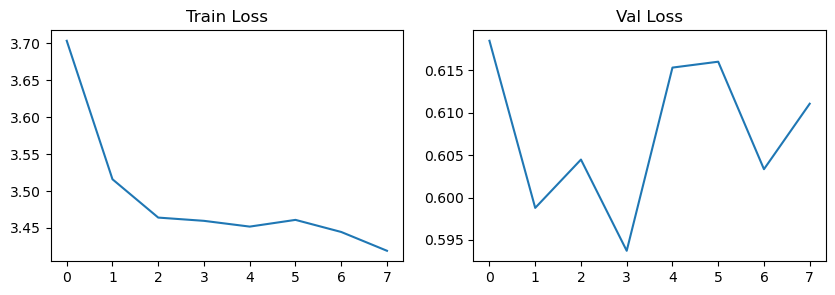

In [35]:
model.eval()
fig, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(train_loss_history)
axes[0].set_title('Train Loss')
axes[1].plot(val_loss_history)
axes[1].set_title('Val Loss')

In [36]:
model.fc = nn.Identity()

batch_size = 256
valloader = DataLoader(valset, batch_size=batch_size, shuffle=True, num_workers=4)

embeddings = np.zeros((batch_size * len(valloader), 2048))
labels = np.zeros(batch_size * len(valloader))
stratum = np.zeros(batch_size * len(valloader))

model.eval()
with torch.no_grad():
    for i, (images, label, strata) in enumerate(tqdm(valloader)):

        if len(label) != batch_size:
            continue

        images, label = images.to(device), label.to(device)
        features = model(images)
        embeddings[i * batch_size: (i + 1) * batch_size] = features.cpu().numpy()
        labels[i * batch_size: (i + 1) * batch_size] = label.cpu().numpy()
        stratum[i * batch_size: (i + 1) * batch_size] = strata.cpu().numpy()

100%|██████████| 5/5 [00:02<00:00,  2.37it/s]


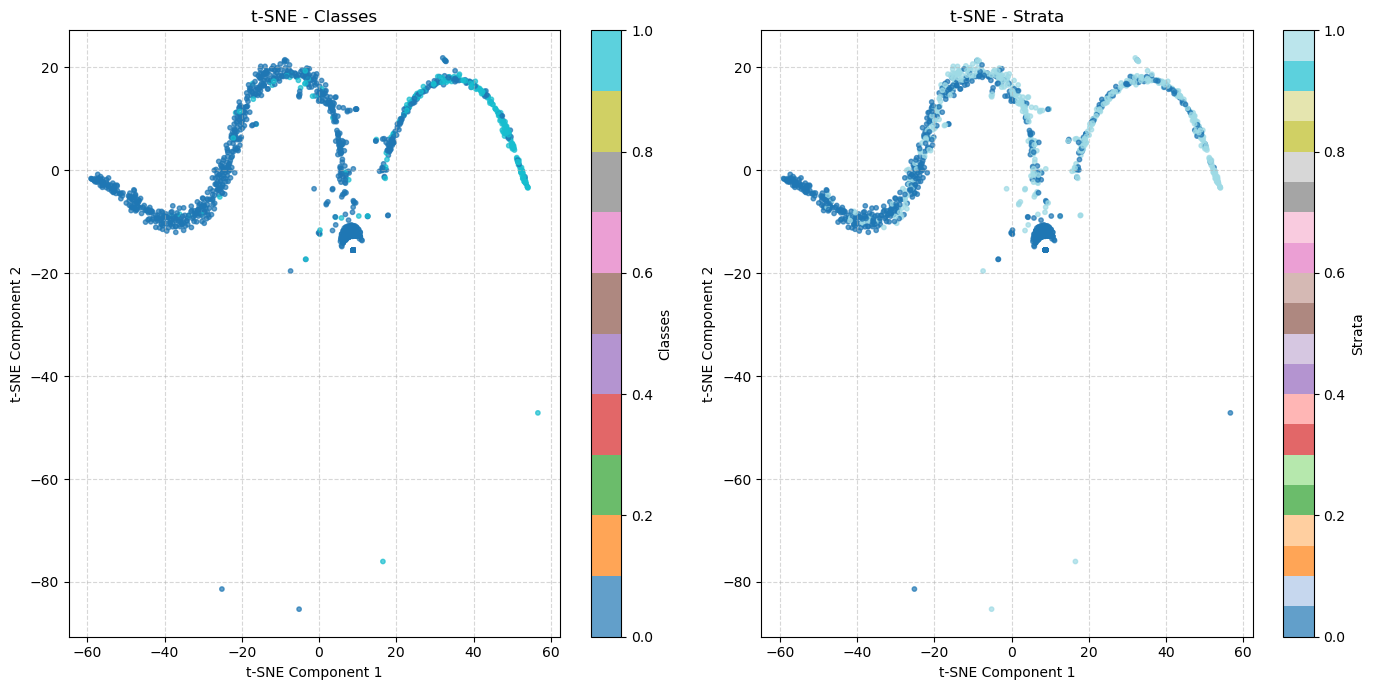

In [37]:
tsne_visualization(embeddings, labels, stratum, title="t-SNE")

In [38]:
model.fc = nn.Sequential(nn.Linear(2048, 128), nn.GELU(), nn.Linear(128, 2))
model.fc = nn.Sequential(nn.Linear(2048, 2))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

train_accuracy = []
val_accuracy = []

epochs = 10

trainloader, valloader = DataLoader(trainset, batch_size=512, shuffle=True, num_workers=4), DataLoader(valset, batch_size=512, shuffle=False, num_workers=4)

In [ ]:
for epoch in range(epochs):
    model.train()
    train_loss = 0
    total_steps = 0
    correct = 0
    total = 0
    for i, (images, labels, _) in enumerate(tqdm(trainloader)):
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_steps +=1
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_accuracy.append(correct / total)    
    tqdm.write(f'Epoch: {epoch}, Loss: {train_loss / total_steps}, Accuracy: {correct / total}')

    model.eval()
    with torch.no_grad():
        val_loss = 0
        total_steps = 0
        correct = 0
        total = 0
        for i, (images, labels, _) in enumerate(valloader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            total_steps += 1
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        val_accuracy.append(correct / total)
    
    tqdm.write(f'Epoch: {epoch}, Val Loss: {val_loss / total_steps}, Val Accuracy: {correct / total}')

100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

Epoch: 0, Loss: 0.7496135115623475, Accuracy: 0.03941605839416058


Epoch: 0, Val Loss: 0.698083221912384, Val Accuracy: 0.2535446205170976


100%|██████████| 10/10 [00:06<00:00,  1.55it/s]

Epoch: 1, Loss: 0.6593892097473144, Accuracy: 0.8523461939520334


Epoch: 1, Val Loss: 0.6491053899129232, Val Accuracy: 0.7889908256880734


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]

Epoch: 2, Loss: 0.5799373984336853, Accuracy: 0.9924921793534932


Epoch: 2, Val Loss: 0.6056973139444987, Val Accuracy: 0.8165137614678899


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

Epoch: 3, Loss: 0.5117708712816238, Accuracy: 0.9949947862356622


Epoch: 3, Val Loss: 0.5693872570991516, Val Accuracy: 0.823185988323603


 70%|███████   | 7/10 [00:05<00:02,  1.20it/s]
